## Introduction

    Assignment: SQL analysis on IMDB data

The IMDB dataset here refers to the relational database whose schema is given ahead. It has 13 different tables. The table Movie is the main table which binds all the others directly or indirectly with the primary key `MID`. Let's start by importing the libraries we need.

In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3

In [694]:
os.listdir()

['questions.pdf',
 'imdb analysis using SQL.ipynb',
 'db_schema.jpeg',
 'Db-IMDB.db',
 '.ipynb_checkpoints']

## The schema

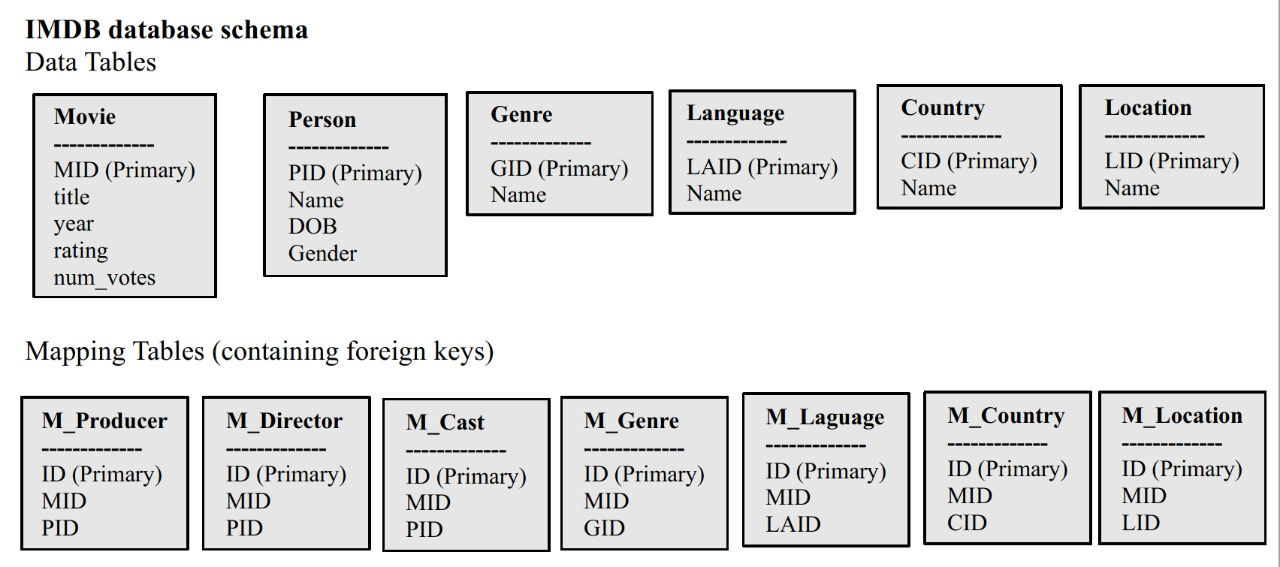

In [3]:
from IPython.display import Image
Image('db_schema.jpeg')

In [3]:
os.path.abspath('questions.pdf')

'/home/tanmay/work/github_projects/my_projects/imdb/questions.pdf'

## The questions

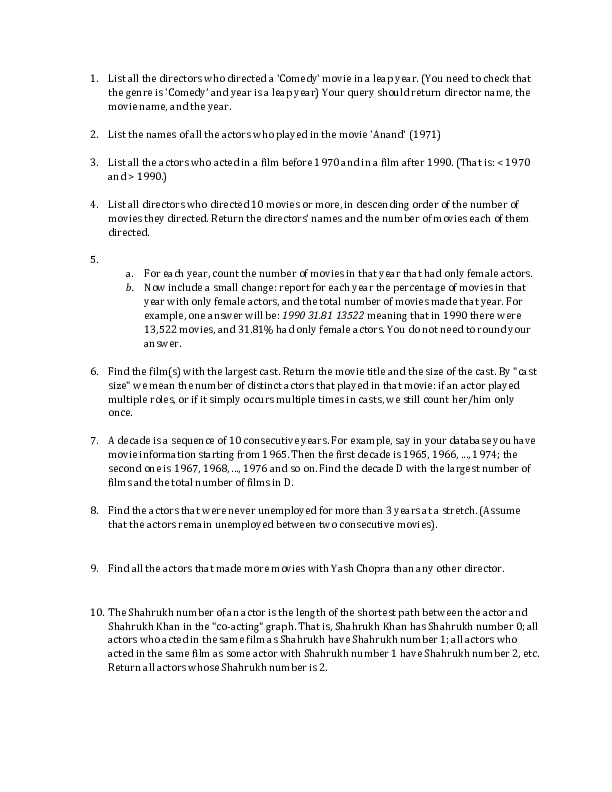

In [696]:
from wand.image import Image as WImage
img = WImage(filename=r'questions.pdf', height=900, width=700)
img

## Connect to the sqlite database

In [151]:
con = sqlite3.connect('Db-IMDB.db')

df_movie = pd.read_sql_query('select * from movie', con)
df_genre_mapping = pd.read_sql_query('select * from M_genre', con)
df_director = pd.read_sql_query('select * from m_director', con)
df_genre = pd.read_sql_query('select * from Genre', con)
df_person = pd.read_sql_query('select * from person', con)
df_cast_mapping = pd.read_sql_query('select * from M_cast', con)

In [3]:
df_movie.head()

,index,MID,title,year,rating,num_votes
0,0,tt2388771,Mowgli,2018,6.6,21967
1,1,tt5164214,Ocean's Eight,2018,6.2,110861
2,2,tt1365519,Tomb Raider,2018,6.4,142585
3,3,tt0848228,The Avengers,2012,8.1,1137529
4,4,tt8239946,Tumbbad,2018,8.5,7483


## Clean the data

There are certain quirks in this data, such as extra spaces at the beginning of `Name`. Here's an example. There are two separate records for the person `Andy Serkis`. Note the space at the beginning of the second name.

In [115]:
df_person[df_person.Name.isin(
    ['Andy Serkis', ' Andy Serkis', 'Ang Lee', ' Ang Lee'])]

,PID,Name,Gender
4,nm0785227,Andy Serkis,Male
32253,nm0000487,Ang Lee,None
36821,nm0785227,Andy Serkis,Male
36837,nm0000487,Ang Lee,None


Extra characters at the beginning of `year`

In [5]:
df_movie.year.value_counts().tail(10)

III 2017    1
I 2005      1
I 1997      1
II 2009     1
I 1983      1
III 2016    1
I 2012      1
I 1996      1
VI 2015     1
IV 2017     1
Name: year, dtype: int64

In [152]:
# Removing trailing spaces from people's names
df_person.Name = df_person.Name.str.strip()

# Strip invalid characters from the column "year"
df_movie.year = df_movie.year.str.strip('I ').str.strip('II ').str.strip(
    'III ').str.strip('IV ').str.strip('V ').str.strip('VI ').str.strip(
        'XVII ').str.strip()

# strip spaces from PID and MID
df_person.PID = df_person.PID.str.strip()
df_director.PID = df_director.PID.str.strip()
df_movie.MID = df_movie.MID.str.strip()
df_director.MID = df_director.MID.str.strip()
df_cast_mapping.PID = df_cast_mapping.PID.str.strip()

In [153]:
# create new column YEAR in movies which is a datetime64 object
df_movie['YEAR'] = df_movie.year.astype('datetime64')

In [154]:
df_movie.year = df_movie.year.astype('int')

## Drop unnecessary index columns

In [ ]:
df_cast_mapping.drop('index', axis=1, inplace=True)
df_director.drop(['index', 'ID'], axis=1, inplace=True)
df_genre.drop('index', axis=1, inplace=True)
df_genre_mapping.drop(['index','ID'], axis=1, inplace=True)
df_movie.drop('index', axis=1, inplace=True)
df_person.drop('index', axis=1, inplace=True)

# Q. Directors who directed a comedy movie in leap year

In [117]:
df_01 = pd.merge(pd.merge(pd.merge(pd.merge(df_movie,
                                            df_genre_mapping,
                                            on='MID'),
                                   df_genre,
                                   on='GID'),
                          df_director,
                          on='MID'),
                 df_person,
                 on='PID',
                 suffixes=('_genre', '_director'))

In [119]:
df_01[(df_01.Name_genre.str.contains('Comedy'))
      & (df_01.YEAR.dt.is_leap_year)].drop_duplicates()[[
          'Name_director', 'title', 'year', 'Name_genre'
      ]]

,Name_director,title,year,Name_genre
7,Anurag Kashyap,Gangs of Wasseypur,2012,"Action, Comedy, Crime"
41,Priyadarshan,Hera Pheri,2000,"Action, Comedy, Crime"
47,Priyadarshan,Kamaal Dhamaal Malamaal,2012,"Comedy, Drama"
48,Priyadarshan,Muskurahat,1992,"Comedy, Drama"
51,Priyadarshan,Mere Baap Pehle Aap,2008,"Comedy, Drama, Romance"
54,Priyadarshan,Hulchul,2004,"Action, Comedy, Drama"
151,David Dhawan,Saajan Chale Sasural,1996,"Comedy, Drama"
155,David Dhawan,Mujhse Shaadi Karogi,2004,"Comedy, Drama, Romance"
157,David Dhawan,Kunwara,2000,"Comedy, Drama, Romance"
167,David Dhawan,Dulhan Hum Le Jayenge,2000,"Comedy, Drama, Romance"


# Q. Names of all actors in the movie 'Anand'

In [121]:
pd.merge(pd.merge(df_movie[df_movie.title == 'Anand'],
                  df_cast_mapping,
                  on='MID'),
         df_person,
         on='PID')[['Name', 'title', 'Gender', 'year']]

,Name,title,Gender,year
0,Rajesh Khanna,Anand,Male,1971
1,Amitabh Bachchan,Anand,Male,1971
2,Sumita Sanyal,Anand,Female,1971
3,Ramesh Deo,Anand,Male,1971
4,Seema Deo,Anand,Female,1971
5,Asit Kumar Sen,Anand,Male,1971
6,Dev Kishan,Anand,Male,1971
7,Atam Prakash,Anand,Male,1971
8,Lalita Kumari,Anand,Female,1971
9,Savita,Anand,Female,1971


# Q. All the actors who acted in a film before 1970 and after 1990

In [122]:
g_03 = pd.merge(pd.merge(df_movie, df_cast_mapping, on='MID'),
                df_person,
                on='PID').groupby('Name')

In [123]:
df_03 = g_03.filter(lambda x: ((x['year'] < 1970).any() & (x['year'] > 1990).
                               any()))

In [126]:
df_03.sort_values(['Name', 'year'])[['Name', 'title','year']].head(5)

,Name,title,year
12107,A.K. Hangal,Teesri Kasam,1966
12109,A.K. Hangal,Shagird,1967
12120,A.K. Hangal,Saat Hindustani,1969
12094,A.K. Hangal,Guddi,1971
12134,A.K. Hangal,Mere Apne,1971


In [128]:
df_03.groupby(['Name'])['year'].agg(['min', 'max']).reset_index().rename(
    {
        'min': 'min year',
        'max': 'max year'
    }, axis=1).head(50)

,Name,min year,max year
0,A.K. Hangal,1966,2012
1,Aachi Manorama,1966,2013
2,Abbas,1948,2006
3,Abdul,1949,2017
4,Abhi Bhattacharya,1956,1994
5,Achala Sachdev,1954,2008
6,Adil,1958,2016
7,Ajay,1955,2017
8,Ajit,1952,2006
9,Akashdeep,1960,2010


# Q. Directors who directed 10 or more movies

In [129]:
df_04 = pd.merge(pd.merge(
    df_movie, df_director, on='MID'), df_person, on='PID').drop_duplicates()

In [130]:
df_04.head()

,MID,title,year,rating,num_votes,YEAR,decade,PID,Name,Gender
0,tt2388771,Mowgli,2018,6.6,21967,2018-01-01,9,nm0785227,Andy Serkis,Male
2,tt5164214,Ocean's Eight,2018,6.2,110861,2018-01-01,9,nm0002657,Gary Ross,None
3,tt1365519,Tomb Raider,2018,6.4,142585,2018-01-01,9,nm1012385,Roar Uthaug,None
4,tt0848228,The Avengers,2012,8.1,1137529,2012-01-01,9,nm0923736,Joss Whedon,None
5,tt8239946,Tumbbad,2018,8.5,7483,2018-01-01,9,nm9751348,Rahi Anil Barve,None


In [132]:
g_04 = df_04.groupby('PID')

g_04.filter(lambda x: x['MID'].nunique() >= 10).groupby(
    'Name', as_index=False)['MID'].count().sort_values(
        'MID', ascending=False).rename({'MID': 'Number of movies directed'},
                                       axis=1).head(20)

,Name,Number of movies directed
7,David Dhawan,39
23,Mahesh Bhatt,35
43,Ram Gopal Varma,30
35,Priyadarshan,30
55,Vikram Bhatt,29
14,Hrishikesh Mukherjee,27
57,Yash Chopra,21
5,Basu Chatterjee,19
48,Shakti Samanta,19
50,Subhash Ghai,18


# Q. For each year, count the number of movies that had only female actors in it

In [133]:
df_05_1 = pd.merge(pd.merge(df_movie, df_cast_mapping, on='MID'),
                   df_person,
                   on='PID')
df_05_1.head(5)

,MID,title,year,rating,num_votes,YEAR,decade,PID,ID,Name,Gender
0,tt2388771,Mowgli,2018,6.6,21967,2018-01-01,9,nm0000288,0,Christian Bale,Male
1,tt2388771,Mowgli,2018,6.6,21967,2018-01-01,9,nm0000949,1,Cate Blanchett,Female
2,tt5164214,Ocean's Eight,2018,6.2,110861,2018-01-01,9,nm0000949,47,Cate Blanchett,Female
3,tt2388771,Mowgli,2018,6.6,21967,2018-01-01,9,nm1212722,2,Benedict Cumberbatch,Male
4,tt2388771,Mowgli,2018,6.6,21967,2018-01-01,9,nm0365140,3,Naomie Harris,Female


In [134]:
df_05_1.Gender.unique()

array(['Male', 'Female', None], dtype=object)

In [135]:
_only_female_cast = df_05_1.groupby(
    'MID').filter(lambda x: (x['Gender'] == 'Female').all()).groupby(
        'year', as_index=False)['MID'].count().rename(
            {'MID': 'Number of movies with only Female actors'}, axis=1)

In [136]:
_only_female_cast

,year,Number of movies with only Female actors
0,1939,2
1,1999,11
2,2000,11
3,2018,2


## Q. year, only female actors, total number of movies

In [137]:
_movies_per_year = df_05_1.groupby(
    'year', as_index=True)['MID'].nunique().reset_index().rename(
        {'MID': 'Total Number of Movies'}, axis=1)

In [138]:
_comparison = pd.merge(_movies_per_year, _only_female_cast, how='left', on = 'year').fillna(0)
_comparison

,year,Total Number of Movies,Number of movies with only Female actors
0,1931,1,0.0
1,1936,3,0.0
2,1939,2,2.0
3,1941,1,0.0
4,1943,1,0.0
5,1946,2,0.0
6,1947,2,0.0
7,1948,3,0.0
8,1949,3,0.0
9,1950,2,0.0


In [139]:
_comparison[
    'percent_movies_with_only_female_actors'] = _comparison['Number of movies with only Female actors'] / _comparison[
        'Total Number of Movies'] * 100

In [140]:
_comparison

,year,Total Number of Movies,Number of movies with only Female actors,percent_movies_with_only_female_actors
0,1931,1,0.0,0.000000
1,1936,3,0.0,0.000000
2,1939,2,2.0,100.000000
3,1941,1,0.0,0.000000
4,1943,1,0.0,0.000000
5,1946,2,0.0,0.000000
6,1947,2,0.0,0.000000
7,1948,3,0.0,0.000000
8,1949,3,0.0,0.000000
9,1950,2,0.0,0.000000


# Q. Movies with the largest cast size

In [141]:
df_05 = pd.merge(df_movie, df_cast_mapping, on = 'MID')

In [142]:
df_05.groupby('title')[['PID']].nunique().rename({
    'PID': 'Cast Size'
}, axis=1).reset_index().sort_values('Cast Size', ascending=False).head(10)

,title,Cast Size
2231,Ocean's Eight,238
297,Apaharan,233
1128,Gold,215
2138,My Name Is Khan,213
582,Captain America: Civil War,191
1091,Geostorm,170
2877,Striker,165
21,2012,154
2365,Pixels,144
3277,Yamla Pagla Deewana 2,140


# Q. Decade D with the largest number of films

In [157]:
df_movie.year.min(), df_movie.year.max()

(1931, 2018)

In [158]:
def decade(x):
    
    decades = [dec for dec in range(df_movie.year.min(), df_movie.year.max(), 10)]
    
    for ix, d in enumerate(decades):
        if x <= d:
            return ix + 1
    return ix + 1

In [159]:
df_movie = pd.concat(
    [df_movie, df_movie.year.map(decade).rename('decade')], axis=1)

In [160]:
df_movie.decade.value_counts(dropna=False).reset_index().rename(
    {
        'index': 'decade',
        'decade': 'Number of movies in decade'
    }, axis=1)

,decade,Number of movies in decade
0,9,1941
1,8,610
2,7,369
3,6,270
4,5,175
5,4,84
6,3,19
7,2,6
8,1,1


# Q. Actors who were never unemployed for more than 3 years

In [161]:
df_08 = pd.merge(pd.merge(df_movie, df_cast_mapping, on='MID'),
                df_person,
                on='PID')

In [162]:
df_08.drop_duplicates(subset=['MID', 'PID', 'year'], inplace=True)

In [163]:
df_081 = df_08.sort_values(['Name', 'year'])[['Name', 'PID', 'title', 'year']]

In [164]:
# Added gap between consecutive movies
df_082 = pd.concat([
    df_081,
    df_081.groupby(df_081['PID'])['year'].diff().rename('gap in years').fillna(0)
],
                  axis=1)

In [165]:
df_082.head()

,Name,PID,title,year,gap in years
80632,'Ganja' Karuppu,nm2128968,Sandai Kozhi,2005,0.0
80633,'Ganja' Karuppu,nm2128968,Pazhani,2008,3.0
79480,'Lee' George Quinones,nm0704042,Bomb the System,2002,0.0
45616,'Musafir' Radio Performing,nm8644387,Rock On!!,2008,0.0
76882,'Nandha' Saravanan,nm5163714,Nandha,2001,0.0


In [166]:
g_082 = df_082.groupby('PID')

In [167]:
df_083 = g_082.filter( lambda x: (x['gap in years'] <= 3).all() )

In [168]:
df_083['gap in years'].replace({0: np.nan}, inplace=True)
df_083.sample(20)

/home/tanmay/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Name,PID,title,year,gap in years
86053,Janardhan Chowdary,nm2902521,50 Lakh,2007,NaN
23943,Vaunisha Kapoor,nm6870504,Guest iin London,2017,NaN
83374,Kinkar Sinha,nm1580148,Anubhav,1971,NaN
52919,Ronald Cardew,nm0136411,North West Frontier,1959,NaN
15254,Jane Hamer,nm5709457,Gold,2018,NaN
83372,Rainer F. Brusten,nm1158528,Anubhav,1971,NaN
83099,Chaitanya Sinh,nm1224983,Everybody Says I'm Fine!,2001,NaN
4032,Anurag Arora,nm3189957,Raees,2017,1.0
86476,Suneet Kochar,nm2897677,Life! Camera Action...,2012,NaN
73909,Frank Faylen,nm0269709,Footsteps in the Dark,1941,NaN


# Q. More movies with Yash Chopra than any other directors

In [169]:
df_090 = pd.merge(pd.merge(pd.merge(df_movie, df_director, on='MID'),
                           df_person,
                           on='PID'),
                  df_cast_mapping,
                  on='MID',
                  suffixes=('_director', '_actor')).drop(
                      labels=['num_votes', 'decade', 'Gender'], axis=1)

In [170]:
df_090.rename({'Name':'director_name'}, axis=1, inplace=True)

In [171]:
df_090.head()

,MID,title,year,rating,YEAR,PID_director,director_name,PID_actor,ID
0,tt2388771,Mowgli,2018,6.6,2018-01-01,nm0785227,Andy Serkis,nm0000288,0
1,tt2388771,Mowgli,2018,6.6,2018-01-01,nm0785227,Andy Serkis,nm0000949,1
2,tt2388771,Mowgli,2018,6.6,2018-01-01,nm0785227,Andy Serkis,nm1212722,2
3,tt2388771,Mowgli,2018,6.6,2018-01-01,nm0785227,Andy Serkis,nm0365140,3
4,tt2388771,Mowgli,2018,6.6,2018-01-01,nm0785227,Andy Serkis,nm0785227,4


In [172]:
g_090 = df_090.groupby('PID_actor')

In [173]:
df_091 = g_090.filter(lambda x: (x['director_name'] == 'Yash Chopra').any()
                    ).sort_values('PID_actor').drop_duplicates()

In [174]:
df_091.sample(5)

,MID,title,year,rating,YEAR,PID_director,director_name,PID_actor,ID
63987,tt0222024,Hum Tumhare Hain Sanam,2002,5.5,2002-01-01,nm1147556,K.S. Adiyaman,nm0622186,19381
63157,tt0248012,Fiza,2000,6.2,2000-01-01,nm0006659,Khalid Mohamed,nm0006433,18721
110839,tt0313495,Prem Geet,1981,7.8,1981-01-01,nm0411541,Sudesh Issar,nm0044796,41022
56675,tt0101437,Beta,1992,6.3,1992-01-01,nm0409791,Indra Kumar,nm0438463,65588
42839,tt0119285,Hero No. 1,1997,6.1,1997-01-01,nm0223522,David Dhawan,nm0025630,34924


In [175]:
g_091 = df_091.groupby(['PID_actor', 'director_name'])

In [176]:
# total number of actors who've done at least one film with Yash Chopra than any other director
df_091.PID_actor.nunique()

430

In [177]:
df_092 = g_091['MID'].count().reset_index().rename({
    'MID': 'count'
}, axis=1).sort_values(['PID_actor', 'count'],
                       ascending=False).drop_duplicates('PID_actor',
                                                        keep='first')

df_092.sample(20)

,PID_actor,director_name,count
1328,nm0044343,Rakeysh Omprakash Mehra,2
7440,nm5138567,Yash Chopra,1
7208,nm3157251,Yash Chopra,1
4422,nm0611552,Karan Johar,3
5799,nm0837126,Asit Sen,1
7413,nm4958954,Yash Chopra,1
2132,nm0201711,Shakti Samanta,4
1748,nm0080149,Hrishikesh Mukherjee,5
5552,nm0789374,B.R. Chopra,3
7523,nm7076286,Yash Chopra,1


In [178]:
# Number of actors who did the highest number of films with Yash Chopra is
# simply the number records in the above dataframe where director == Yash Chopra
# because this df is sorted on the number of movies and duplicates for PID_actor
# have been removed

df_093 = df_092[df_092.director_name == 'Yash Chopra'].sort_values(
    'count', ascending=False)

In [179]:
df_093.PID_actor = df_093.PID_actor.map(dict(df_person[['PID', 'Name']].values))

In [180]:
df_093.rename({'PID_actor': 'Actor name'}, axis=1).head(30)

,Actor name,director_name,count
4961,Jagdish Raj,Yash Chopra,11
3766,Manmohan Krishna,Yash Chopra,10
2650,Iftekhar,Yash Chopra,9
474,Shashi Kapoor,Yash Chopra,7
2479,Rakhee Gulzar,Yash Chopra,5
5030,Waheeda Rehman,Yash Chopra,5
5732,Neetu Singh,Yash Chopra,4
5167,Achala Sachdev,Yash Chopra,4
2055,Sudha Chopra,Yash Chopra,3
1942,Leela Chitnis,Yash Chopra,3


# Q. Shahrukh number

In [181]:
df_10 = pd.merge(pd.merge(df_movie, df_cast_mapping, on='MID'),
                 df_person,
                 on='PID')  #.query("Name == 'Shahrukh Khan'")

Find out all movies SRK was in

In [182]:
srk_movies = df_10.query("Name == 'Shah Rukh Khan'")['MID'].unique().tolist()

Get index of all records where movie is an srk movie and it's not SRK himself

In [183]:
index_srk_co_actors = df_10[(df_10.MID.isin(srk_movies))
                            & (df_10.Name != 'Shah Rukh Khan')].index

Set the srk_number of all those records to 1

In [184]:
df_10.loc[index_srk_co_actors, 'srk_number'] = 1

Get the actors whose srk_number is 1

In [185]:
srk_number_1_actors = df_10[df_10.srk_number == 1]['PID'].unique().tolist()

Get the movies of the actors with srk_number 1

In [186]:
srk_number_1_movies = df_10[df_10.PID.isin(srk_number_1_actors) & (
    df_10.Name != 'Shah Rukh Khan') & (df_10.srk_number != 1)].MID.unique()

Set the srk_number of all those records to 2

In [187]:
df_10.loc[df_10[df_10.MID.isin(srk_number_1_movies)].index, 'srk_number'] = 2

In [188]:
df_10.srk_number.value_counts(dropna=False)

2.0    77645
NaN     5805
1.0     3402
Name: srk_number, dtype: int64

In [114]:
df_10.sample(30)

,MID,title,year,rating,num_votes,YEAR,decade,PID,ID,Name,Gender,srk_number
28849,tt0473367,Jaane Tu... Ya Jaane Na,2008,7.5,22562,2008-01-01,9,nm1405359,12262,Imran Khan,Male,2.0
41709,tt0449999,Kabhi Alvida Naa Kehna,2006,6.1,16374,2006-01-01,9,nm1999213,13250,Oliver Martin,Male,1.0
19242,tt3309662,Jackpot,2013,2.2,635,2013-01-01,9,nm0787462,35571,Naseeruddin Shah,Male,2.0
59815,tt0187109,Gurudev,1993,4.9,105,1993-01-01,8,nm0151539,54405,Chandrashekhar,Male,2.0
43178,tt2556308,Holiday,2014,7.4,22160,2014-01-01,9,nm3083004,20431,Aashin A. Shah,None,2.0
67168,tt1773015,Phas Gaye Re Obama,2010,7.5,4463,2010-01-01,9,nm4357108,29012,Veena Kapur,Female,2.0
48247,tt0079221,Gol Maal,1979,8.6,14778,1979-01-01,6,nm1193461,16310,Siddharth,None,2.0
52658,tt0230991,Zabardast,1985,5.5,67,1985-01-01,7,nm1090174,58707,Ravindra Kapoor,Male,2.0
65912,tt0158587,Dhund,1973,7.3,397,1973-01-01,6,nm0451387,56042,Padma Khanna,Female,2.0
23985,tt0410952,Charas: A Joint Effort,2004,5.3,278,2004-01-01,9,nm0159167,58069,Uday Chopra,None,2.0
